In [1]:
from datetime import datetime

import tensorflow as tf
import sys
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
import os
import stellargraph as sg
from matplotlib import pyplot as plt
from numpy.testing import measure
from sklearn.semi_supervised.tests.test_self_training import X_train, X_test, y_train, y_test
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph
from stellargraph import datasets
from tensorflow.python.keras.benchmarks.benchmark_util import measure_performance

In [2]:
num_classes = 5
img_rows, img_cols = 48, 48
batch_size = 32
num_channel = 1
base_dir = 'gambar data primer suara noise mix/'

In [3]:
train_data_dir = os.path.join('gambar data primer suara noise mix 721/', 'train')
validation_data_dir = os.path.join('gambar data primer suara noise mix 721/', 'val')
test_data_dir = os.path.join('gambar data primer suara noise mix 721/', 'test')

Found 1765 images belonging to 5 classes.
Found 502 images belonging to 5 classes.
Found 256 images belonging to 5 classes.
{'marah': 0, 'netral': 1, 'sedih': 2, 'senang': 3, 'terkejut': 4} {'marah': 0, 'netral': 1, 'sedih': 2, 'senang': 3, 'terkejut': 4} {'marah': 0, 'netral': 1, 'sedih': 2, 'senang': 3, 'terkejut': 4}
(32, 48, 48, 1)


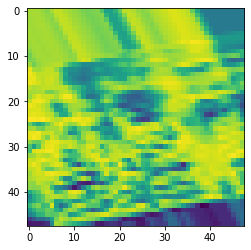

(32, 48, 48, 1)


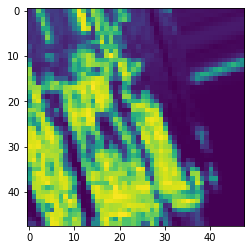

(32, 48, 48, 1)


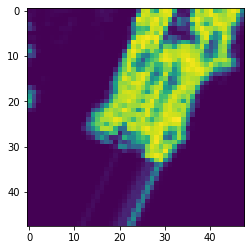

(32, 48, 48, 1)


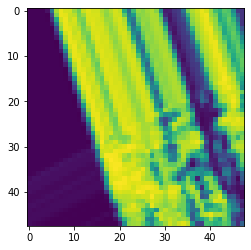

(32, 48, 48, 1)


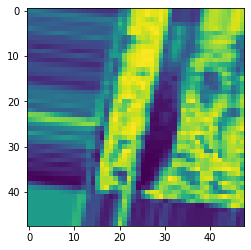

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

print(train_generator.class_indices, validation_generator.class_indices, test_generator.class_indices)

for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [8]:
model = Sequential()

# Block-1

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-2

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-4

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [10]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('D:/Data fazrun/dataset7/suara_CM_lr001_mix.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

#earlystop = EarlyStopping(monitor='val_loss',
#                          min_delta=0,
#                          patience=3,
#                          verbose=1,
#                          restore_best_weights=True
#                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
nb_train_samples = 1765
nb_validation_samples = 502
epochs = 100

In [12]:
hist = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/100
55/55 [==============================] - 109s 825ms/step - loss: 2.3982 - accuracy: 0.2285 - val_loss: 7.0737 - val_accuracy: 0.2208

Epoch 00001: val_loss improved from inf to 7.07367, saving model to D:/Data fazrun/dataset7\suara_CM_lr001_mix.h5
Epoch 2/100
55/55 [==============================] - 6s 114ms/step - loss: 2.0804 - accuracy: 0.2666 - val_loss: 9.3138 - val_accuracy: 0.2125

Epoch 00002: val_loss did not improve from 7.07367
Epoch 3/100
55/55 [==============================] - 6s 113ms/step - loss: 1.8942 - accuracy: 0.2810 - val_loss: 1.9949 - val_accuracy: 0.2667

Epoch 00003: val_loss improved from 7.07367 to 1.99485, saving model to D:/Data fazrun/dataset7\suara_CM_lr001_mix.h5
Epoch 4/100
55/55 [==============================] - 6s 114ms/step - loss: 1.8206 - accuracy: 0.2897 - val_loss: 3.0532 - val_accuracy: 0.1896

Epoch 00004: val_loss did not improve from 1.99485
Epoch 5/100
55/55 [==============================] - 6s 113ms/step - loss: 1.6658 - accu

55/55 [==============================] - 7s 118ms/step - loss: 1.3286 - accuracy: 0.4132 - val_loss: 1.3140 - val_accuracy: 0.4250

Epoch 00038: val_loss did not improve from 1.06690
Epoch 39/100
55/55 [==============================] - 7s 121ms/step - loss: 1.3048 - accuracy: 0.4310 - val_loss: 1.3187 - val_accuracy: 0.4229

Epoch 00039: val_loss did not improve from 1.06690
Epoch 40/100
55/55 [==============================] - 7s 128ms/step - loss: 1.3353 - accuracy: 0.4368 - val_loss: 1.3196 - val_accuracy: 0.4229

Epoch 00040: val_loss did not improve from 1.06690

Epoch 00040: ReduceLROnPlateau reducing learning rate to 2.0480002416167767e-11.
Epoch 41/100
55/55 [==============================] - 7s 123ms/step - loss: 1.3622 - accuracy: 0.4045 - val_loss: 1.3146 - val_accuracy: 0.4271

Epoch 00041: val_loss did not improve from 1.06690
Epoch 42/100
55/55 [==============================] - 7s 121ms/step - loss: 1.3203 - accuracy: 0.4287 - val_loss: 1.3316 - val_accuracy: 0.4250

Ep

55/55 [==============================] - 6s 115ms/step - loss: 1.3166 - accuracy: 0.4357 - val_loss: 1.3397 - val_accuracy: 0.4187

Epoch 00075: val_loss did not improve from 1.06690
Epoch 76/100
55/55 [==============================] - 6s 115ms/step - loss: 1.3182 - accuracy: 0.4287 - val_loss: 1.3141 - val_accuracy: 0.4292

Epoch 00076: val_loss did not improve from 1.06690

Epoch 00076: ReduceLROnPlateau reducing learning rate to 8.388609197901593e-20.
Epoch 77/100
55/55 [==============================] - 6s 116ms/step - loss: 1.3278 - accuracy: 0.4420 - val_loss: 1.3283 - val_accuracy: 0.4333

Epoch 00077: val_loss did not improve from 1.06690
Epoch 78/100
55/55 [==============================] - 6s 116ms/step - loss: 1.3370 - accuracy: 0.4293 - val_loss: 1.3302 - val_accuracy: 0.4354

Epoch 00078: val_loss did not improve from 1.06690
Epoch 79/100
55/55 [==============================] - 7s 125ms/step - loss: 1.3373 - accuracy: 0.4316 - val_loss: 1.3161 - val_accuracy: 0.4250

Epo

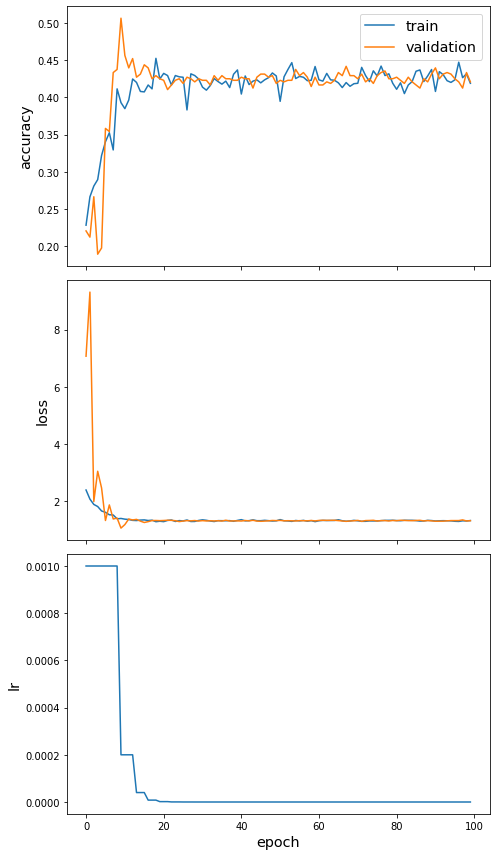

In [13]:
sg.utils.plot_history(hist)
plt.savefig('GraphEmotionsoundVGGmix.png')
plt.show()

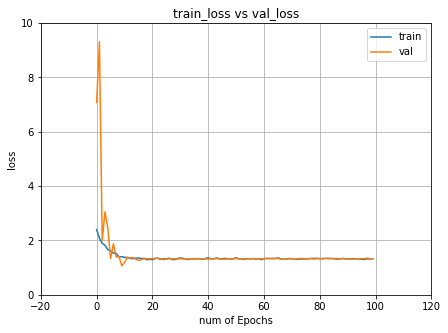

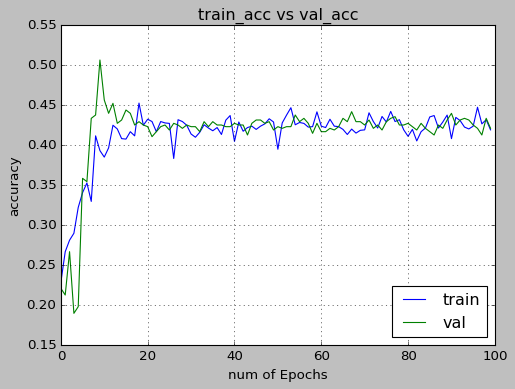

In [14]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)#####################
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [15]:
X_train, y_train = next(train_generator)
X_val, y_val = next(validation_generator)
X_test, y_test = next(test_generator)

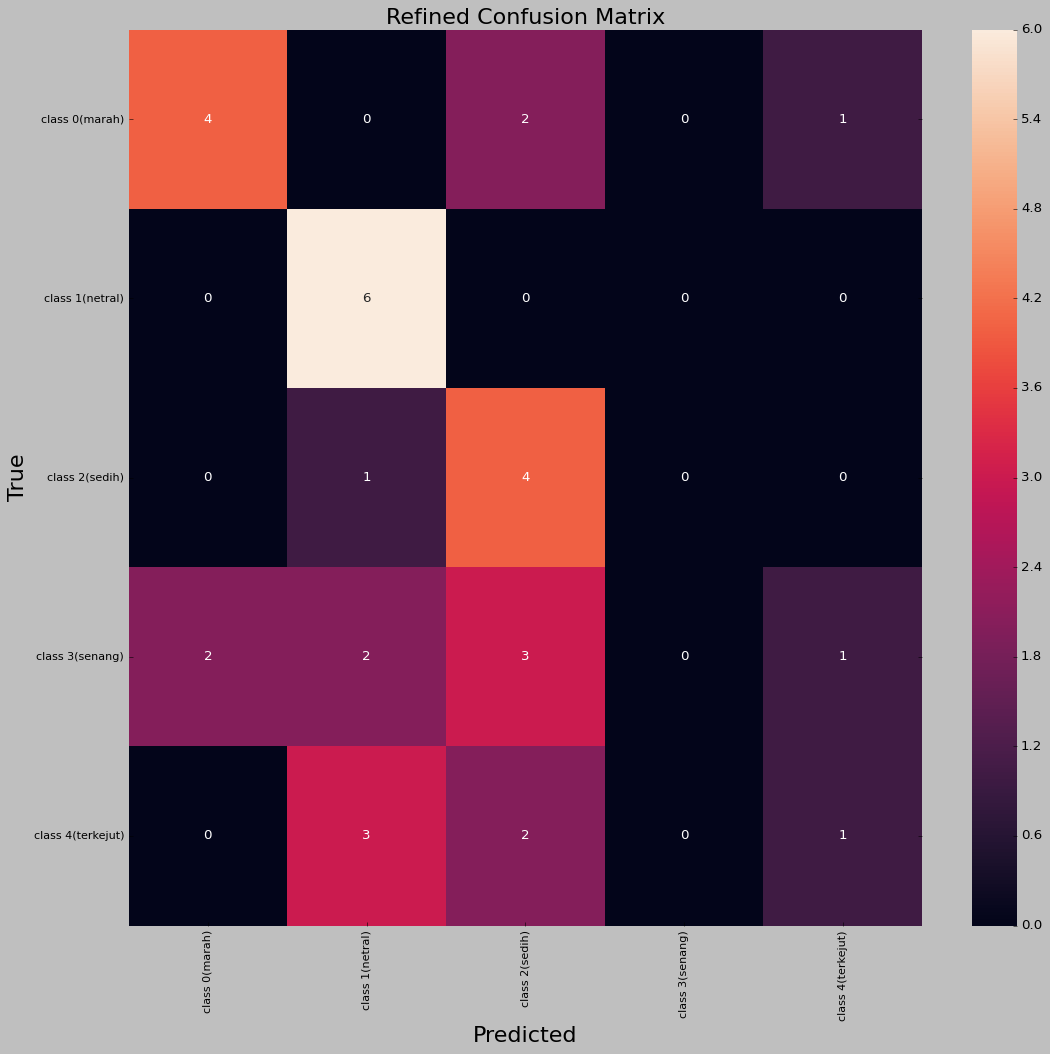

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = load_model('D:/Data fazrun/dataset7/suara_CM_lr001_mix.h5')

predictions = model.predict(X_test, steps=len(X_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
y_pred = np.argmax(predictions, axis=-1)

y_true=np.argmax(y_test, axis=-1)

cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
labels = ['class 0(marah)', 'class 1(netral)', 'class 2(sedih)', 'class 3(senang)', 'class 4(terkejut)']
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('CMSuaraEmotionVGGmix.png')
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score : ",precision_score(y_true, y_pred, 
                                           average='micro'))
print("Recall Score : ",recall_score(y_true, y_pred, 
                                     average='micro'))

Precision Score :  0.46875
Recall Score :  0.46875


In [18]:
from sklearn.metrics import f1_score

print("F1 Score : ",f1_score(y_true, y_pred, 
                             average='micro'))

F1 Score :  0.46875
